# Pengerjaan Tugas Deep Learning Week 4 Menggunakan PyTorch

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [1]:
# !pip install numpy pandas matplotlib scikit-learn torch torchtext
%pip install numpy pandas matplotlib scikit-learn torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


## 2. Mengimpor Library yang Dibutuhkan

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb # Menggunakan dataset IMDB dari TensorFlow Keras
import io
import re
from collections import Counter
import time
from copy import deepcopy

## 3. Mendefinisikan Parameter dan Pre-processing Dataset IMDb

In [3]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 400
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
EPOCHS = 20
LEARNING_RATE = 0.001

# Memeriksa apakah GPU tersedia
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {DEVICE}")

# Langkah 1: Mengunduh dataset IMDB
print("Memuat dataset IMDb...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(f"Jumlah sampel training: {len(x_train)}")
print(f"Jumlah sampel testing: {len(x_test)}")

# Langkah 2: Pra-pemrosesan data, termasuk padding
print("Pra-pemrosesan data...")
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = seq[:maxlen]
        else:
            padded_sequences[i, :len(seq)] = seq
    return padded_sequences

x_train = pad_sequences(x_train, MAXLEN)
x_test = pad_sequences(x_test, MAXLEN)

# Mengonversi data ke tensor PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(DEVICE)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(DEVICE)


# Mengonversi data ke TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Membuat DataLoader untuk pelatihan, validasi, dan pengujian
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Menggunakan device: cpu
Memuat dataset IMDb...
Jumlah sampel training: 25000
Jumlah sampel testing: 25000
Pra-pemrosesan data...


## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [4]:
# Fungsi untuk melatih model
def train_model(model, train_loader, criterion, optimizer, device, epochs, model_name):
    model.train()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
    best_epoch = 0
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        train_accuracy = correct / total
        train_loss = train_loss / (batch_idx + 1)
        
        # Validasi
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                predicted = (outputs.data > 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_accuracy = val_correct / val_total
        val_loss = val_loss / (batch_idx + 1)
        
        history['accuracy'].append(train_accuracy)
        history['loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
            
        # Simpan model terbaik berdasarkan loss validasi
        if val_loss < min(history['val_loss'][:-1], default=float('inf')):
            print(f"Checkpoint: Model disimpan sebagai 'model_pytorch_{model_name}.pth' (validation loss terendah = {val_loss:.4f})")
            best_epoch = epoch + 1
            best_val_loss = val_loss
            torch.save(deepcopy(model.state_dict()), f'model_pytorch_{model_name}.pth')
    
    print(f"Pelatihan selesai. Model terbaik pada epoch = {best_epoch}, dengan validation loss = {best_val_loss} disimpan.")
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [5]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = 0
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data).squeeze(1)
            test_loss += criterion(output, target).item()
            
            pred = (output > 0.5).float()
            all_probs.extend(output.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    # Menghitung ROC curve dan AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    
    results = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': all_preds,
        'y_pred_prob': all_probs
    }
    
    return results

## 6. Menyiapkan Fungsi Visualisasi

In [21]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_pytorch_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_pytorch.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_pytorch.png')
    plt.show()


# A. RNN dengan PyTorch

## 1. Menyusun Model RNN


In [7]:
# Definisi Model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=1)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        hidden = hidden2[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))

# Inisialisasi model
model_rnn = RNNModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

## 2. Melatih Model

In [8]:
# Loss function dan optimizer
criterion = nn.BCELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)

# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, train_loader, criterion, optimizer_rnn, DEVICE, epochs=EPOCHS, model_name='rnn')

Melatih model RNN...
Epoch: 1/20, Loss: 0.7016, Accuracy: 0.5045, Val Loss: 0.6937, Val Accuracy: 0.5038
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.6937)
Epoch: 2/20, Loss: 0.6934, Accuracy: 0.5156, Val Loss: 0.6953, Val Accuracy: 0.5052
Epoch: 3/20, Loss: 0.6882, Accuracy: 0.5238, Val Loss: 0.6936, Val Accuracy: 0.5029
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.6936)
Epoch: 4/20, Loss: 0.6803, Accuracy: 0.5292, Val Loss: 0.6994, Val Accuracy: 0.5020
Epoch: 5/20, Loss: 0.6663, Accuracy: 0.5397, Val Loss: 0.7064, Val Accuracy: 0.5079
Epoch: 6/20, Loss: 0.6486, Accuracy: 0.5563, Val Loss: 0.7223, Val Accuracy: 0.5011
Epoch: 7/20, Loss: 0.6353, Accuracy: 0.5633, Val Loss: 0.7394, Val Accuracy: 0.5063
Epoch: 8/20, Loss: 0.6278, Accuracy: 0.5660, Val Loss: 0.7340, Val Accuracy: 0.5084
Epoch: 9/20, Loss: 0.6250, Accuracy: 0.5688, Val Loss: 0.7438, Val Accuracy: 0.5028
Epoch: 10/20, Loss: 0.6188, Accur

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [9]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_loader, criterion, DEVICE)
print("Evaluasi model RNN selesai.")
print(f"Loss: {result_rnn['loss']:.4f}")
print(f"Accuracy: {result_rnn['accuracy']:.4f}")
print(f"Precision: {result_rnn['precision']:.4f}")
print(f"Recall: {result_rnn['recall']:.4f}")
print(f"F1 Score: {result_rnn['f1']:.4f}")
print(f"AUC: {result_rnn['auc']:.4f}")

Evaluasi model RNN selesai.
Loss: 0.7659
Accuracy: 0.5041
Precision: 0.5193
Recall: 0.1107
F1 Score: 0.1825
AUC: 0.5088


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

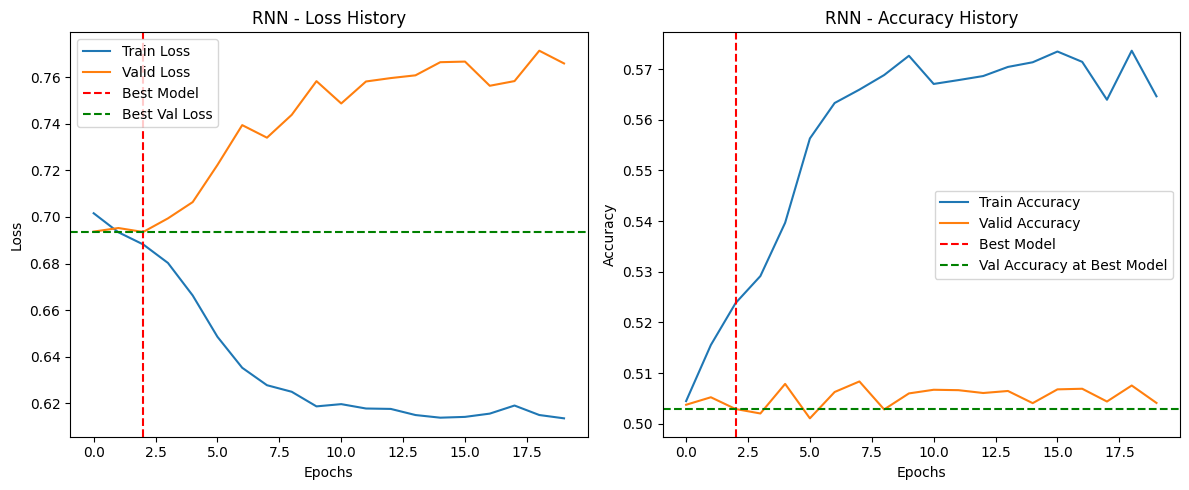

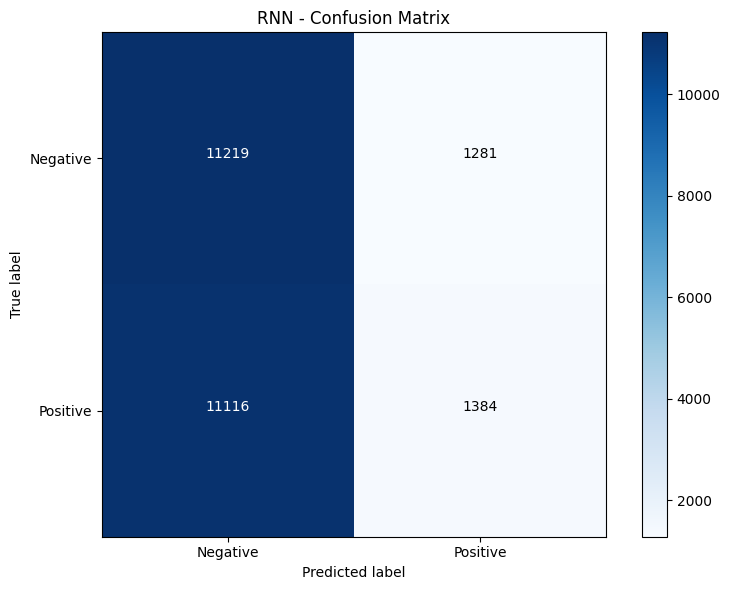

In [22]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "RNN")

# Plotting confusion matrix
y_pred_rnn = np.array(result_rnn['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn, "RNN")

## 5. Menyimpan Model

In [ ]:
# Menyimpan model
#torch.save(model_rnn.state_dict(), 'model_pytorch_rnn.pth')
#print("Model RNN disimpan sebagai 'model_pytorch_rnn.pth'")

# B. LSTM dengan PyTorch

## 1. Menyusun Model LSTM


In [23]:
# Definisi Model LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, cell_type='RNN'):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=1)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, (hidden1, _) = self.rnn1(embedded)
        output2, (hidden2, _) = self.rnn2(output1)
        hidden = hidden2[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))
    
model_lstm = LSTMModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

## 2. Melatih Model

In [24]:
# Inisialisasi loss function dan optimizer
criterion = nn.BCELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_loader, criterion, optimizer_lstm, DEVICE, epochs=EPOCHS, model_name='lstm')

Melatih model LSTM...
Epoch: 1/20, Loss: 0.6937, Accuracy: 0.5039, Val Loss: 0.6925, Val Accuracy: 0.5058
Checkpoint: Model disimpan sebagai 'model_pytorch_lstm.pth' (validation loss terendah = 0.6925)
Epoch: 2/20, Loss: 0.6878, Accuracy: 0.5158, Val Loss: 0.6921, Val Accuracy: 0.5101
Checkpoint: Model disimpan sebagai 'model_pytorch_lstm.pth' (validation loss terendah = 0.6921)
Epoch: 3/20, Loss: 0.6769, Accuracy: 0.5282, Val Loss: 0.6931, Val Accuracy: 0.5036
Epoch: 4/20, Loss: 0.6802, Accuracy: 0.5211, Val Loss: 0.7012, Val Accuracy: 0.5144
Epoch: 5/20, Loss: 0.6463, Accuracy: 0.5526, Val Loss: 0.7158, Val Accuracy: 0.5162
Epoch: 6/20, Loss: 0.6233, Accuracy: 0.5579, Val Loss: 0.7476, Val Accuracy: 0.5168
Epoch: 7/20, Loss: 0.6076, Accuracy: 0.5722, Val Loss: 0.7636, Val Accuracy: 0.5144
Epoch: 8/20, Loss: 0.6048, Accuracy: 0.5789, Val Loss: 0.7571, Val Accuracy: 0.5224
Epoch: 9/20, Loss: 0.5473, Accuracy: 0.6870, Val Loss: 0.5910, Val Accuracy: 0.7478
Checkpoint: Model disimpan seb

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [25]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_loader, criterion, DEVICE)
print("Evaluasi model LSTM selesai.")
print(f"Loss: {result_lstm['loss']:.4f}")
print(f"Accuracy: {result_lstm['accuracy']:.4f}")
print(f"Precision: {result_lstm['precision']:.4f}")
print(f"Recall: {result_lstm['recall']:.4f}")
print(f"F1 Score: {result_lstm['f1']:.4f}")
print(f"AUC: {result_lstm['auc']:.4f}")

Evaluasi model LSTM selesai.
Loss: 0.6791
Accuracy: 0.8285
Precision: 0.8500
Recall: 0.7977
F1 Score: 0.8230
AUC: 0.8941


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

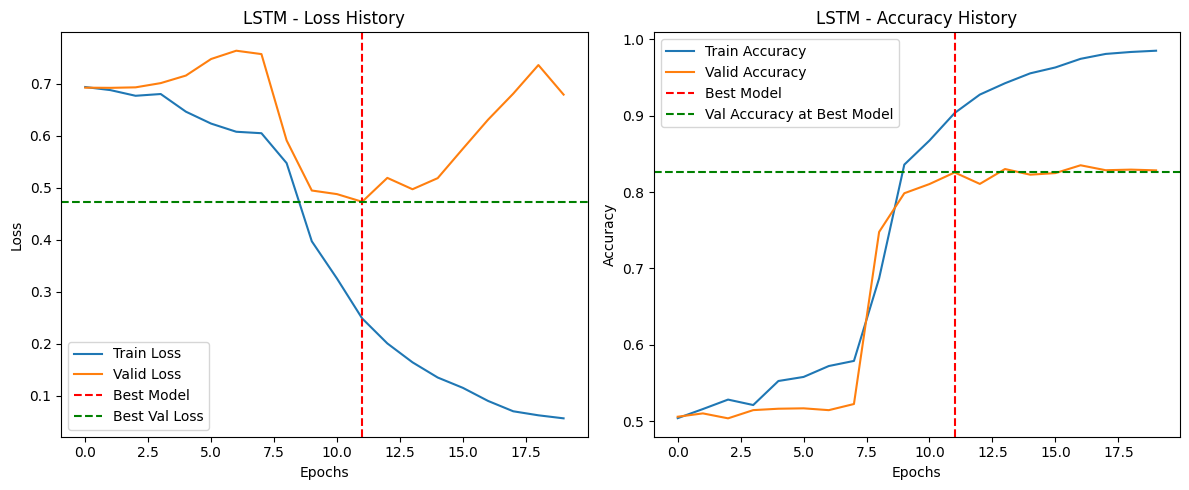

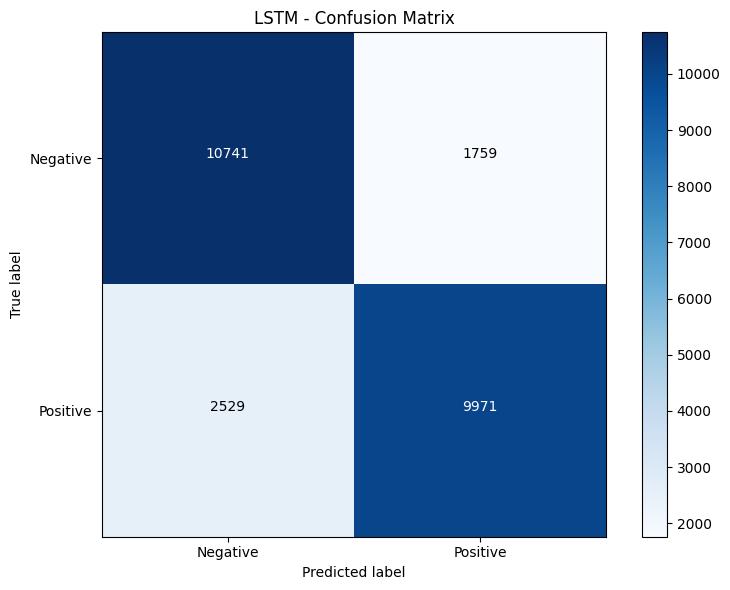

In [26]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "LSTM")

# Plotting confusion matrix
y_pred_lstm = np.array(result_lstm['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")

## 5. Menyimpan Model

In [27]:
# Menyimpan model
#torch.save(model_lstm.state_dict(), 'model_pytorch_lstm.pth')
#print("Model LSTM disimpan sebagai 'model_pytorch_lstm.pth'")

# C. GRU dengan PyTorch

## 1. Menyusun Model GRU


In [28]:
# Definisi Model GRU
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, cell_type='RNN'):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=1)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        hidden = hidden2[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))
    
print("\n===== Model GRU =====")
model_gru = GRUModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)


===== Model GRU =====


## 2. Melatih Model

In [29]:
# Inisialisasi loss function dan optimizer
criterion = nn.BCELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)

# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_loader, criterion, optimizer_gru, DEVICE, epochs=EPOCHS, model_name='gru')

Melatih model gru...
Epoch: 1/20, Loss: 0.7020, Accuracy: 0.5047, Val Loss: 0.6931, Val Accuracy: 0.5028
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.6931)
Epoch: 2/20, Loss: 0.6896, Accuracy: 0.5306, Val Loss: 0.6272, Val Accuracy: 0.6608
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.6272)
Epoch: 3/20, Loss: 0.5114, Accuracy: 0.7643, Val Loss: 0.3765, Val Accuracy: 0.8408
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.3765)
Epoch: 4/20, Loss: 0.2837, Accuracy: 0.8910, Val Loss: 0.3050, Val Accuracy: 0.8744
Checkpoint: Model disimpan sebagai 'model_pytorch_gru.pth' (validation loss terendah = 0.3050)
Epoch: 5/20, Loss: 0.1755, Accuracy: 0.9401, Val Loss: 0.3127, Val Accuracy: 0.8799
Epoch: 6/20, Loss: 0.1062, Accuracy: 0.9673, Val Loss: 0.3465, Val Accuracy: 0.8751
Epoch: 7/20, Loss: 0.0623, Accuracy: 0.9839, Val Loss: 0.4583, Val Accuracy: 0.8718
Epoch: 8/20

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [30]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
result_gru = evaluate_model(model_gru, test_loader, criterion, DEVICE)
print("Evaluasi model GRU selesai.")
print(f"Loss: {result_gru['loss']:.4f}")
print(f"Accuracy: {result_gru['accuracy']:.4f}")
print(f"Precision: {result_gru['precision']:.4f}")
print(f"Recall: {result_gru['recall']:.4f}")
print(f"F1 Score: {result_gru['f1']:.4f}")
print(f"AUC: {result_gru['auc']:.4f}")


Evaluasi model GRU...
Evaluasi model GRU selesai.
Loss: 0.6897
Accuracy: 0.8632
Precision: 0.8463
Recall: 0.8878
F1 Score: 0.8665
AUC: 0.9356


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

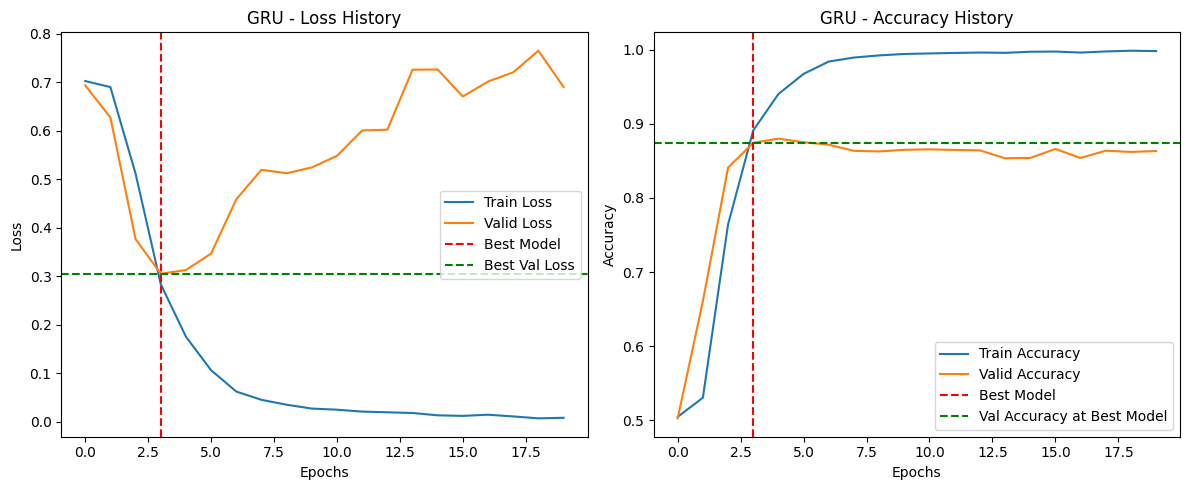

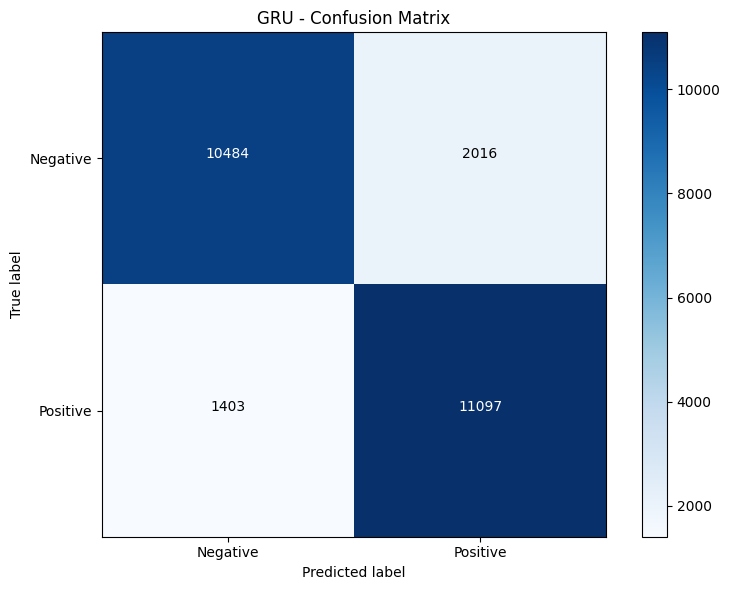

In [31]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "GRU")

# Plotting confusion matrix
y_pred_gru = np.array(result_gru['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_gru, "GRU")

## 5. Menyimpan Model

In [32]:
# Menyimpan model
#torch.save(model_gru.state_dict(), 'model_pytorch_gru.pth')
#print("Model GRU disimpan sebagai 'model_pytorch_gru.pth'")

# Perbandingan antara model

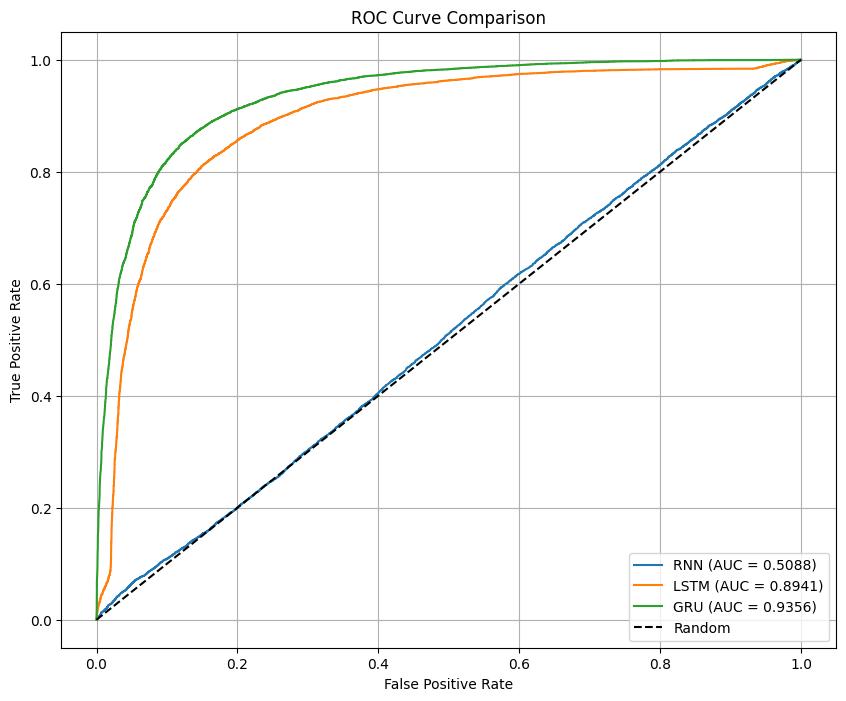

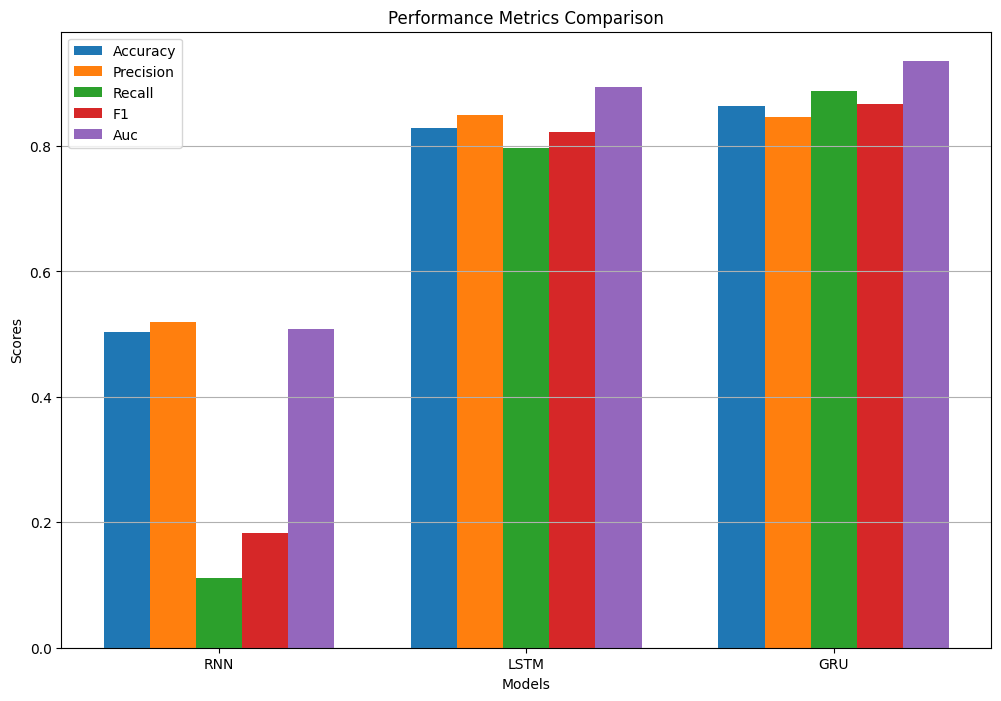

In [33]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': result_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)